In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Cross-Entropy Method (CEM) for Reinforcment Learning (NOTES)
## Policy
* Policy is a universal function (kind of a list of rules) that help solve RL problem `=` maximize total reward
***
## Policy expressed in terms of probability distribution
Policy can be approximated via neural network with set of weights $\theta_i \in \vec{\theta}$. 
$$\pi = \pi(\vec{\theta})$$
Each weight $\theta_i$ is sampled from a normal distribution $\mathcal{N}(\mu, \sigma)$ with specific mean $\mu$ and stdev $\sigma$ (or variance $\sigma^2$). <br>
$$\theta_i \sim \mathcal{N}(\mu_{i}, \sigma_{i})$$
$$\mathcal{N}(x, \mu, \sigma)=\frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2}$$
Using this approach policy $\pi$ is parametrized by $\mu$ and $\sigma$.

$$\pi = \pi(\vec{\theta}) = \pi(\theta_0(\mu_{0}, \sigma_{0}),\theta_1(\mu_{1}, \sigma_{1}),\dots) = \pi(\mu_{0}, \sigma_{0}, \mu_{1}, \sigma_{1}, \dots)$$

Distributions for $\theta_x$ and $\theta_y$ should be independent. Their combined distribution can be constructed via multiplication
$$\mathcal{N}(x, \sigma_x, \mu_x, y, \sigma_y,  \mu_y) = \mathcal{N}(x, \mu_x, \sigma_x) \cdot \mathcal{N}(y, \mu_y, \sigma_y) = 
\frac{1}{\sigma_x\sigma_y 2\pi}e^{-\frac{1}{2} ((\frac{x-\mu_x}{\sigma_x})^2+ (\frac{y-\mu_y}{\sigma_y})^2)}
$$

For case of `k` independent variables $x_i$ combined distribution can be and expressed via multivariate normal distribution
$$\mathcal{N}(\vec{x},\vec{\Sigma},\vec{\mu}) = \frac{1}{\sqrt{(2\pi)^k |\vec{\Sigma}|}} e^{-\frac{1}{2} (\vec{x}-\vec{\mu})^T \vec{\Sigma}^{-1}(\vec{x}-\vec{\mu})}$$

Where $$\vec{\Sigma} = \mathrm{diag}(\vec{\sigma})$$
***
Q: Why can we generate weights via distribution which has a range of output values?

A: 
    You may think that each true weight $\theta_i$ can be recovered from a distribution  if $\mu_i \rightarrow \theta_i$ and $\sigma_i \rightarrow 0$
    <br>So distribution takes form of delta function $\delta_i(x) = \delta_i(x - \theta_i)$ and produces only value $\theta_i$.
***

## Shaping distribution to achieve best policy

CEM method is derivative free. Instead it uses evolution type algorithm, which has no access inside NN, so its treated as a black box.<br>
1. Initialize $\vec{\mu}$ and $\vec{\sigma}$ to random values,
1. Sample `S` different sets of weights from multivariate distribution,
1. Evaluate loss function on all samples,
1. Take top % performing samples
1. Calculate their average parameters
1. Generate new samples from multivariate distribution which uses updated parameters
1. Repeat


In a sense, it somewhat resembles gradient descent with a small learning rate. 

Here $\sigma_i$ controls optimizer step and mean value is moved to solution.

Major difference is that we cannot tell which parameter contributed the most.

***

We can compare it to pseudo code [presented](https://youtu.be/aUrX-rP_ss4) by CEM popularizer John Schulman

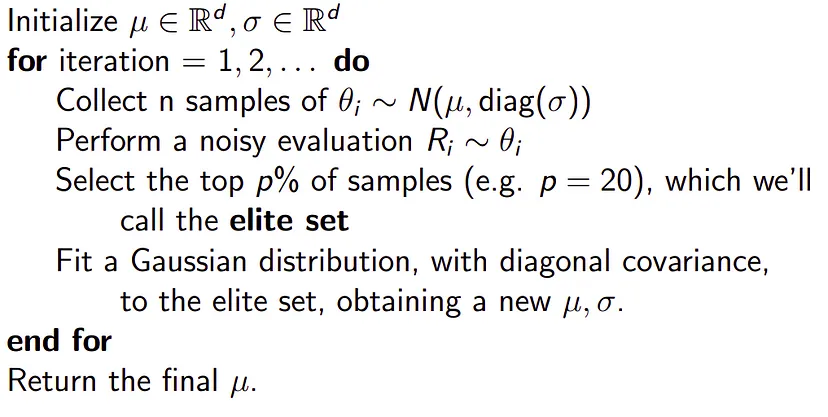
***

## Example
### In the following example we will recover entries of rotation matrix via CEM

1. Using multivariate normal distribution, with diagonal covariance matrix, we can generate `N` independent normal distributions for N weights

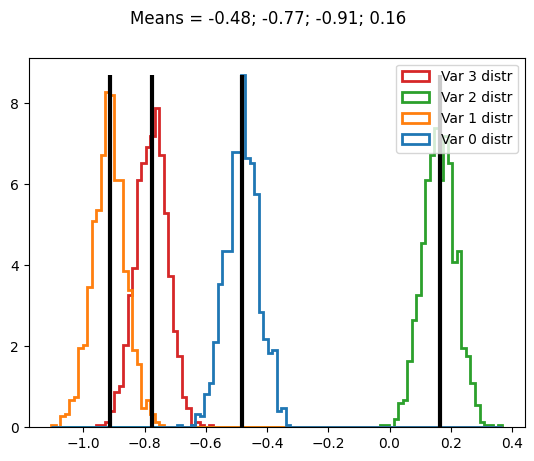

In [2]:
np.random.seed(68)
N_vars  = 4
means   = np.random.uniform(-1,1, size = (N_vars,))
#cov     = np.diag(np.random.randint(1,5, size = (N_vars,)))/(350)
cov     = np.diag(np.ones(N_vars))/350
N_pts   = 1000
samples0 = np.random.multivariate_normal(means, cov, size=N_pts)
h       = plt.hist( samples0, bins = 100, label=[f'Var {i} distr' for i in range(N_vars)], 
                    histtype='step', density=True, lw=2);
for m in means:
    plt.vlines(x=m,ymin= 0, ymax=h[0].max(), lw = 3, colors= 'k')
mns = [f'{k:0.2f}' for k in means]
plt.suptitle("Means = " + '; '.join(sorted(mns)))
plt.legend();

2. Lets pick our target as weights of rotation matrix.
2. Objective function is sum of weights and reward = - loss, so best reward is 0.

In [3]:
rot_angle = np.pi/6
def T(angle):
    return np.array([   [np.cos(angle), -np.sin(angle)],
                        [np.sin(angle),  np.cos(angle)]])

T_rot = T(rot_angle)

def f_reward(samples):
    T_batch = samples.reshape(-1, N_vars)
    reward = -np.linalg.norm(T_batch - T_rot.flatten(), axis = 1)
    return reward

tr = [f'{k:0.2f}' for k in T_rot.flatten()]
print(T_rot.flatten())
f_reward(np.array([T_rot.flatten(),[1,1,1,1], [2,2,2,2],[3,3,3,3]]))

[ 0.8660254 -0.5        0.5        0.8660254]


array([-0.        , -1.59245043, -3.32743096, -5.25430254])

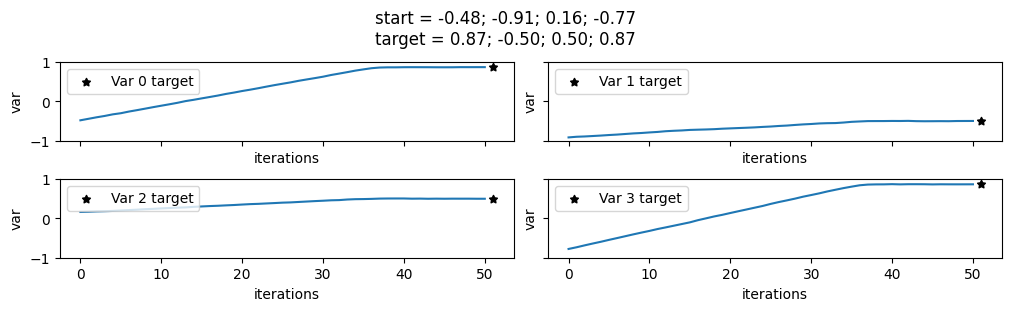

In [4]:
N_ITERS = 50
samples = samples0.copy()
rewards = np.zeros(shape=(N_ITERS + 1))
rewards[0] = f_reward(samples).mean()
coords  = np.zeros(shape=(N_vars, N_ITERS + 1))
coords[:,0] = samples.mean(axis = 0)

PERCENTILE = 70

def f_elite_set(samples):
    reward          = f_reward(samples)
    reward_bound    = np.percentile(reward, PERCENTILE)
    elite_mask      = reward >= reward_bound
    return samples[elite_mask]

for i in range(N_ITERS):
    elite_set   = f_elite_set(samples)
    elite_means = np.mean(elite_set, axis = 0)
    #elite_std = np.std(elite_set, axis = 0)
    #elite_cov = np.diag(elite_std**2)
    elite_cov   = cov
    samples     = np.random.multivariate_normal(elite_means, elite_cov, size=N_pts)
    rewards[i + 1] = f_reward(samples).mean()
    coords[:,i + 1] = elite_means

fig, ax = plt.subplots(N_vars//2,N_vars//2, layout='constrained', sharex = True, sharey = True, figsize = (10,3))
ax = ax.flatten()
for i,y in enumerate(coords):
    #ax[i].scatter(range(len(y)),y, label = 'iterations')
    ax[i].plot(range(len(y)),y)
    ax[i].scatter([len(y + 1)], T_rot.flatten()[i], c = 'k', marker=(5, 1), s = 35, label = f'Var {i} target')
    ax[i].set_ylim(-1,1)
    ax[i].legend(loc='upper left')
    ax[i].set_xlabel('iterations')
    ax[i].set_ylabel('var')
plt.suptitle("start = " + '; '.join(mns) + '\n' + "target = " + '; '.join(tr));

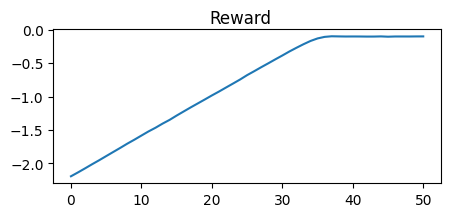

In [5]:
plt.figure(figsize=(5,2))
plt.plot(rewards);
plt.suptitle('Reward');

In [6]:
np.std([1,3])

1.0